# Group Progject Part 3

Ananov Georgy - 890980   
Le Duong - 894834  
Nguyen Tam - 906968  
Pham Hieu - 895118  

## Library Imports

In [112]:
import psycopg2
from psycopg2 import Error
from sqlalchemy import create_engine, text
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

## Database connection

First things first, we need to connect to the *PostgreSQL* database we designed and implemented during the previous rounds. We can use methods from the `psycopg2` and `sqlalchemy` libraries to establish a connection and execute SQL queries.

In [ ]:
# Credentials to connect to Postgres database
database="grp21_vaccinedist"   
user='grp21'       
password='B5!BpWYT' 
host='dbcourse2022.cs.aalto.fi'
port= '5432'

try:
    connection = psycopg2.connect(
                                    database=database,              
                                    user=user,       
                                    password=password,   
                                    host=host,
                                    port=port
                                )
    cursor = connection.cursor()
    cursor.execute("SELECT version();")
    record = cursor.fetchone()
    print("You are connected to - ", record, "\n")
    DIALECT = 'postgresql+psycopg2://'
    db_uri = "%s:%s@%s/%s" % (user, password, host, database)
    engine = create_engine(DIALECT + db_uri)
    psql_conn  = engine.connect()

except (Exception, Error) as error:
    print("Error while connecting to PostgreSQL", error)

With the connection established, we can proceed to conducting the analysis tasks.

## Data analysis

### Question 1

Let's start by pulling data about patients and symptoms from the database into a pandas dataframe using an SQL query.

In [ ]:
query = '''
    SELECT ssno, gender, birthday, symptom, date
    FROM patient, diagnosed
    WHERE patient = ssno
'''
df = pd.read_sql(query, psql_conn)
df.head()

Now we can create a table using the dataframe we obtained.

In [ ]:
df.to_sql("patientsymptoms", psql_conn, index = True, if_exists = "replace")

We can check that the table has been successfully inserted into the database.

In [12]:
query = '''
    SELECT *
    FROM patientsymptoms
'''
df = pd.read_sql(query, psql_conn)
df.head()

,index,ssno,gender,birthday,symptom,date
0,0,790503-394M,F,1979-05-03,anaphylaxia,2021-01-30
1,1,000127-4899,F,2000-01-27,blurring of vision,2021-02-01
2,2,090707-295R,F,2009-07-07,chest pain,2021-02-15
3,3,810616-9029,M,1981-06-16,chest pain,2021-04-30
4,4,701127-5340,F,1970-11-27,chills,2021-04-10


### Question 2

For this question we can start by creating a view that lists some information about every performed vaccination.

In [29]:
%%capture

query = '''
    CREATE OR REPLACE VIEW individualvaccination AS
    SELECT attend.patient AS patientssno, attend.date, vaccinedata.name as vaccinetype
    FROM   
        attend 
        NATURAL JOIN 
        vaccinationevent 
        NATURAL JOIN 
        vaccinationbatch 
        NATURAL JOIN 
        vaccinedata
    
'''
psql_conn.execute(query)

We can now use the created view in constructing the desired dataframe.

In [37]:
query = '''
    SELECT ssno AS patientssno, IV1.date AS date1, IV1.vaccinetype ASvaccinetype1,
        IV2.date AS date2, IV2.vaccinetype ASvaccinetype2
    FROM 
        patient
        LEFT JOIN individualvaccination AS IV1 ON ssno = IV1.patientssno
        LEFT JOIN individualvaccination AS IV2 ON ssno = IV2.patientssno AND IV1.date <> IV2.date
'''

df = pd.read_sql(query, psql_conn)
df.sort_values('date1').head()

,patientssno,date1,asvaccinetype1,date2,asvaccinetype2
0,841229-112N,2021-01-30,AstraZeneca,2021-02-14,Comirnaty
32,110929-252V,2021-01-30,Comirnaty,None,None
33,060729-292C,2021-01-30,Comirnaty,None,None
34,070101-326Q,2021-01-30,Comirnaty,None,None
35,880810-358W,2021-01-30,Comirnaty,2021-02-14,Comirnaty


Here I assumed that a patient can only receive one vaccine in any given day. This assumption was also made during the database design process, so nothing new here. 

Now we can proceed to creating a table based on the newly constructed dataframe.

In [34]:
df.to_sql("patientvaccineinfo", psql_conn, if_exists = "append")

query = '''
    SELECT *
    FROM patientvaccineinfo
'''
pd.read_sql(query, psql_conn).head()

,index,patientssno,date1,asvaccinetype1,date2,asvaccinetype2
0,0,841229-112N,2021-01-30,AstraZeneca,2021-02-14,Comirnaty
1,1,780214-1893,2021-01-30,AstraZeneca,None,None
2,2,731122-126T,2021-01-30,AstraZeneca,None,None
3,3,160930-586P,2021-01-30,AstraZeneca,2021-02-14,Comirnaty
4,4,930106-189U,2021-01-30,AstraZeneca,None,None


### Question 3

### Question 4

### Question 5

### Question 6

### Question 7

### Question 8

### Question 9

For this task we can rely on methods from the `pandas` and `matplotlib` libraries, as well as the view `individualvaccination` we created for question 2. 

First let's obtain the dates of first-dose vaccinations and calculate the number of vaccinated patiens by the end of each date. This would be possible to do entirely with SQL, but we chose to conduct part of the calculations in `pandas`. 

In [106]:
query = '''
    SELECT MIN(date) AS date
    FROM individualvaccination
    GROUP BY patientssno
    ORDER BY MIN(date)
'''
df_first_dose = pd.read_sql(query, psql_conn)
df_first_dose["count"] = 1
df_first_dose["count"] = df_first_dose["count"].cumsum()
vax_count = df_first_dose.groupby("date", as_index = False).agg('max')
first_row_df = pd.DataFrame({"date" : datetime.strptime("2021-01-01", "%Y-%m-%d").date(), "count" : 0}, index = [0])
vax_count = pd.concat([first_row_df, vax_count])
vax_count.head()

,date,count
0,2021-01-01,0
0,2021-01-30,32
1,2021-02-14,39
2,2021-03-16,49
3,2021-05-10,78


We can use similar methods to obtain information about counts of patients with two doses.

In [108]:
query = '''
    SELECT MIN(IV2.date) AS date
    FROM individualvaccination AS IV1, individualvaccination AS IV2
    WHERE IV1.date < IV2.date
    GROUP BY IV1.patientssno
    ORDER BY MIN(IV2.date)
'''
df_second_dose = pd.read_sql(query, psql_conn)
df_second_dose["count"] = 1
df_second_dose["count"] = df_second_dose["count"].cumsum()
fully_vax_count = df_second_dose.groupby("date", as_index=False).agg('max')
fully_vax_count = pd.concat([first_row_df, fully_vax_count])
fully_vax_count.head()

,date,count
0,2021-01-01,0
0,2021-02-14,32
1,2021-03-16,39
2,2021-05-10,49
3,2021-05-14,78


Now we can proceed to compiling a plot.

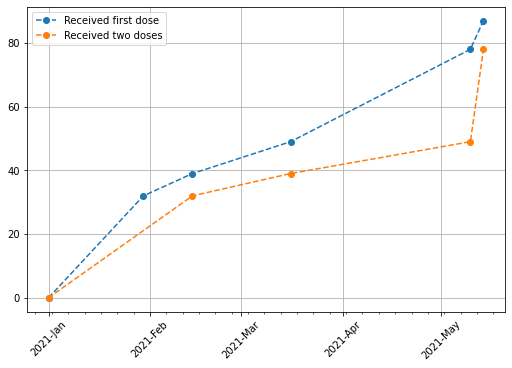

In [127]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5), constrained_layout=True)
ax.plot(vax_count["date"], vax_count["count"],  '--o', label="Received first dose")
ax.plot(fully_vax_count["date"], fully_vax_count["count"],  '--o', label="Received two doses")
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=5))
ax.tick_params(axis = 'x', rotation = 45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
ax.grid(True)
ax.legend()
plt.show()


Note: technically the dashed lines on this plot do not reflect the real intermediate datapoints. A more realistic plot would depict a stepped ladder function, since patients are not getting vaccinated outside of the vaccination event dates. However, since such a plot would be less visually informative and would not reflect the overall trend as well, we have elected to use the plot you can see above. 

### Question 10